To resolve the issues with the previous notebook we need to also predict QP and QN. I have added this to training data. So let's first check the inputs.

In [1]:
import xarray as xr

In [2]:
ds = xr.open_zarr("/Users/noah/Data/0/cb/5239eed9c8d95d8899fca9a6e03f75/ngaqua_data.zarr/")

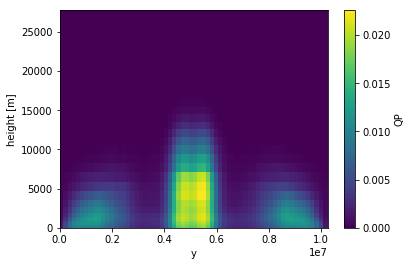

In [3]:
ds.QP.mean(['x', 'time']).plot()

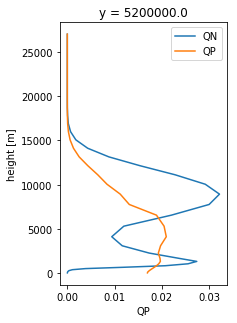

In [4]:
plt.figure(figsize=(3,3*1.61))
ds.QN.mean(['x', 'time']).isel(y=32).plot(label='QN', y='z')
ds.QP.mean(['x', 'time']).isel(y=32).plot(label='QP', y='z')
plt.legend()

At the equator, there is actually a similar amount of QP and QN.

# Training

In [5]:
import pymongo
from bson.objectid import ObjectId
from toolz import get

from pytz import timezone
import pytz

def get_last_runs_n(db, n):
    """List the last n model training runs"""
    return list(db.run.find({}).sort([("start_timestamp", pymongo.DESCENDING)]).limit(n))


def get_batches(db, run_id):
    """Get the losses """
    keys = ['epoch', 'batch', 'loss']
    tuples = [get(keys, doc) for doc in db.batch.find({"run_id": run_id})]
    return pd.DataFrame(tuples, columns=keys).set_index(keys[:2])

def get_epochs(db, run_id):
    """Get the losses """
    return list(db.epoch.find({"run_id": run_id}))


def print_time(time):
    time = time.replace(tzinfo=timezone('UTC')).astimezone(timezone('US/Pacific'))
    date_format='%m/%d/%Y %H:%M:%S %Z'
    return  time.strftime(date_format)


def summarize_run(run_metadata):
    print(run_metadata['git'])
    print(run_metadata['run'])
    print("time started:", print_time(run_metadata['start_timestamp']))
    run_id = run_metadata['_id']
    print("Number of batches done", len(get_batches(db, run_metadata['_id']).loss))
    print("Number of epochs done", len(get_epochs(db, run_metadata['_id'])))

In [6]:
c = pymongo.MongoClient()
db = c.uwnet

In [7]:
run_metadata = get_last_runs_n(db, 10)[0]
summarize_run(run_metadata)

{'rev': 'ad480ed0eef4c17de235b0bdd7afa48bb7ed221b'}
/Users/noah/Data/0/98/d6c98928eee5e2a114e2aad49d18fe
time started: 08/14/2018 11:49:57 PDT
Number of batches done 123
Number of epochs done 3


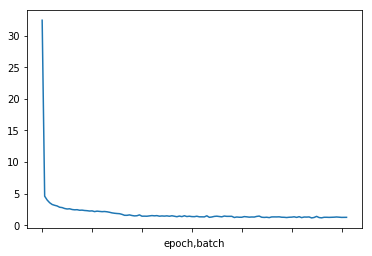

In [8]:
get_batches(db, run_metadata['_id']).loss.plot()

In [9]:
ds = xr.open_dataset("../data/cols.nc")
# ds = xr.open_dataset("../out.nc")

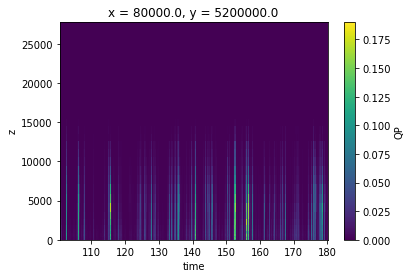

In [10]:
ds.isel(x=0, y=32).sel(time=slice(100, 180)).QP.plot(x='time')

# Results

after experimenting none of the methods for predicting QP and QN seem to work particularly well. The simplest method is to use softplus activation, and to not use QP and QN as inputs to the prediction. I am now training a new modeul

In [11]:

# run_id = get_last_runs_n(db, 1)[0]['_id']
# run_id
run_id = ObjectId('5b732455e6060efbe8327729')

run = db.run.find_one({'_id': run_id})

summarize_run(run)

{'rev': 'ad480ed0eef4c17de235b0bdd7afa48bb7ed221b'}
/Users/noah/Data/0/98/d6c98928eee5e2a114e2aad49d18fe
time started: 08/14/2018 11:49:57 PDT
Number of batches done 123
Number of epochs done 3


In [12]:
run_metadata

{'_id': ObjectId('5b732455e6060efbe8327729'),
 'run': '/Users/noah/Data/0/98/d6c98928eee5e2a114e2aad49d18fe',
 'start_timestamp': datetime.datetime(2018, 8, 14, 18, 49, 57, 357000),
 'training_data': '/Users/noah/Data/0/98/d6c98928eee5e2a114e2aad49d18fe/training_data.zarr',
 'config': {'nseeds': 5,
  'nepochs': 3,
  'paths': [{'path': '/Users/noah/Data/2018-05-30-NG_5120x2560x34_4km_10s_QOBS_EQX/coarse/2d/all.nc',
    'fields': ['LHF',
     'SHF',
     'SOLIN',
     'SST',
     'Prec',
     'SWNS',
     'SWNT',
     'LWNS',
     'LWNT']},
   {'path': '/Users/noah/Data/2018-05-30-NG_5120x2560x34_4km_10s_QOBS_EQX/stagger/3d/all.nc',
    'fields': ['U', 'V']},
   {'path': '/Users/noah/Data/2018-05-30-NG_5120x2560x34_4km_10s_QOBS_EQX/coarse/3d/all.nc',
    'fields': ['QV', 'TABS', 'QN', 'QP', 'QRAD', 'W']},
   {'path': '/Users/noah/Data/2018-05-30-NG_5120x2560x34_4km_10s_QOBS_EQX/stat.nc',
    'fields': ['p', 'RHO']},
   {'path': '/Users/noah/workspace/research/uw-machine-learning-v1/data/

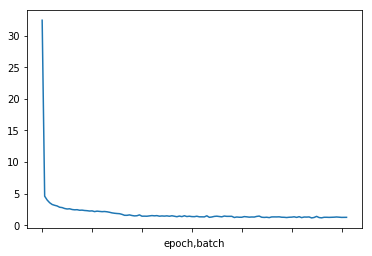

In [13]:
get_batches(db, run_id).loss.plot()

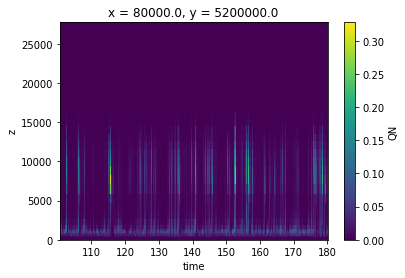

In [14]:
ds.isel(x=0, y=32).sel(time=slice(100, 180)).QN.plot(x='time')

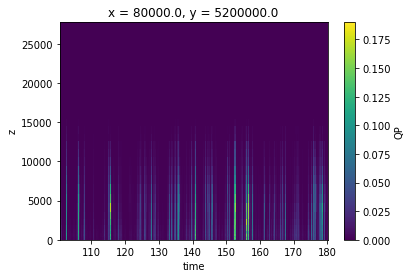

In [15]:
ds.isel(x=0, y=32).sel(time=slice(100, 180)).QP.plot(x='time')

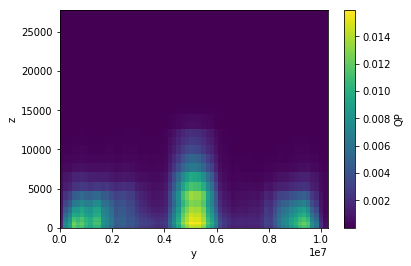

In [16]:
ds.QP.mean(['x', 'time']).plot()

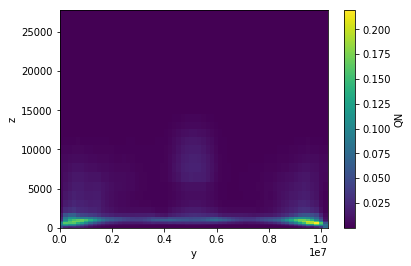

In [17]:
ds.QN.mean(['x', 'time']).plot()

This neural network seems to do a good job.